# Analisi e Preprocessing delle Tecniche MITRE

Questo notebook si occupa dell'elaborazione della colonna MitreTechniques per preparare i dati per l'analisi di classificazione. Include:
1. Caricamento e pulizia dei dati
2. Normalizzazione dei codici MITRE
3. Gestione delle duplicazioni e statistiche
4. One-hot encoding delle tecniche più comuni

In [5]:
# Importazione delle librerie necessarie e caricamento dati
import pandas as pd
import numpy as np
from collections import Counter

# Lettura del dataset
df = pd.read_csv('GUIDE_Train.csv')

# Selezione delle colonne necessarie
df = df[['MitreTechniques']]

print("Shape del dataset:", df.shape)
print("\nPrimi 5 esempi di tecniche MITRE:")
print(df['MitreTechniques'].head())

Shape del dataset: (9516837, 1)

Primi 5 esempi di tecniche MITRE:
0      NaN
1      NaN
2    T1189
3      NaN
4      NaN
Name: MitreTechniques, dtype: object


In [6]:
# Funzione per normalizzare i codici delle tecniche
def normalize_technique_code(technique):
    if pd.isna(technique):
        return 'unknown'
    
    # Split la stringa in tecniche separate
    techniques = str(technique).split(';')
    
    # Normalizza ogni tecnica
    normalized = []
    for t in techniques:
        t = t.strip()
        # Aggiungi 'T' se manca
        if not t.startswith('T') and t != 'unknown':
            t = 'T' + t
        # Prendi solo la parte principale del codice (prima del punto)
        if '.' in t and t != 'unknown':
            t = t.split('.')[0]
        normalized.append(t)
    
    return ';'.join(normalized)

# Applica la normalizzazione
df['MitreTechniques_normalized'] = df['MitreTechniques'].apply(normalize_technique_code)

print("Esempi di normalizzazione:")
for orig, norm in zip(df['MitreTechniques'].head(), df['MitreTechniques_normalized'].head()):
    print(f"Originale: {orig}")
    print(f"Normalizzato: {norm}\n")

Esempi di normalizzazione:
Originale: nan
Normalizzato: unknown

Originale: nan
Normalizzato: unknown

Originale: T1189
Normalizzato: T1189

Originale: nan
Normalizzato: unknown

Originale: nan
Normalizzato: unknown



In [7]:
# Funzione per rimuovere le duplicazioni e calcolare le statistiche
def remove_duplicates_and_count(techniques_str):
    if pd.isna(techniques_str):
        return 'unknown'
    # Converte la stringa in set per rimuovere i duplicati
    unique_techniques = set(techniques_str.split(';'))
    return ';'.join(sorted(unique_techniques))

# Rimuovi le duplicazioni
df['MitreTechniques_unique'] = df['MitreTechniques_normalized'].apply(remove_duplicates_and_count)

# Calcola le occorrenze delle tecniche
all_techniques = []
for techniques in df['MitreTechniques_unique']:
    all_techniques.extend(techniques.split(';'))

# Conta le occorrenze
technique_counts = Counter(all_techniques)

# Stampa le statistiche
print("Top 30 tecniche più comuni:")
for technique, count in sorted(technique_counts.items(), key=lambda x: x[1], reverse=True)[:30]:
    print(f"{technique}: {count}")

print("\nNumero totale di tecniche uniche:", len(technique_counts))

Top 30 tecniche più comuni:
unknown: 5468386
T1566: 1616189
T1078: 1472808
T1110: 190763
T1133: 177415
T1071: 97274
T1059: 91110
T1087: 79838
T1046: 78464
T1190: 52710
T1098: 51850
T1210: 44512
T1559: 43770
T1003: 42745
T1568: 40838
T1008: 40646
T1106: 40487
T1030: 40373
T1204: 37532
T1027: 32806
T1552: 31615
T1105: 28553
T1012: 25546
T1021: 24902
T1048: 22565
T1595: 15812
T1041: 13722
T1018: 13572
T1550: 13563
T1569: 13251

Numero totale di tecniche uniche: 243


In [12]:
# Calcola la soglia minima (0.2% dei record totali)
min_occurrences = len(df) * 0.002

# Seleziona le tecniche che superano la soglia
frequent_techniques = [tech for tech, count in technique_counts.items() 
                      if count >= min_occurrences]

print(f"Soglia minima di occorrenze (0.5%): {min_occurrences:.0f}")
print(f"Numero di tecniche frequenti: {len(frequent_techniques)}")

# Crea una funzione per il one-hot encoding e il conteggio delle tecniche rare
def create_technique_features(techniques_str):
    techniques = set(techniques_str.split(';'))
    
    # Inizializza il dizionario per le feature
    features = {tech: 0 for tech in frequent_techniques}
    features['unknown'] = 0
    
    # Contatore per le tecniche rare
    n_rare = 0
    
    # Popola le feature
    for tech in techniques:
        if tech in frequent_techniques:
            features[tech] = 1
        elif tech == 'unknown':
            features['unknown'] = 1
        else:
            n_rare += 1
    
    # Limita n_rare a 5
    features['n_rare'] = min(n_rare, 5)
    
    return features

# Applica la trasformazione
encoded_df = pd.DataFrame([create_technique_features(tech) for tech in df['MitreTechniques_unique']])

print("\nShape del dataset codificato:", encoded_df.shape)
print("\nPrime 5 righe del dataset codificato:")
print(encoded_df.head())

Soglia minima di occorrenze (0.5%): 19034
Numero di tecniche frequenti: 25

Shape del dataset codificato: (9516837, 26)

Prime 5 righe del dataset codificato:
   unknown  T1078  T1566  T1098  T1059  T1106  T1559  T1133  T1110  T1048  \
0        1      0      0      0      0      0      0      0      0      0   
1        1      0      0      0      0      0      0      0      0      0   
2        0      0      0      0      0      0      0      0      0      0   
3        1      0      0      0      0      0      0      0      0      0   
4        1      0      0      0      0      0      0      0      0      0   

   ...  T1008  T1568  T1087  T1105  T1021  T1012  T1552  T1204  T1027  n_rare  
0  ...      0      0      0      0      0      0      0      0      0       0  
1  ...      0      0      0      0      0      0      0      0      0       0  
2  ...      0      0      0      0      0      0      0      0      0       1  
3  ...      0      0      0      0      0      0      0   

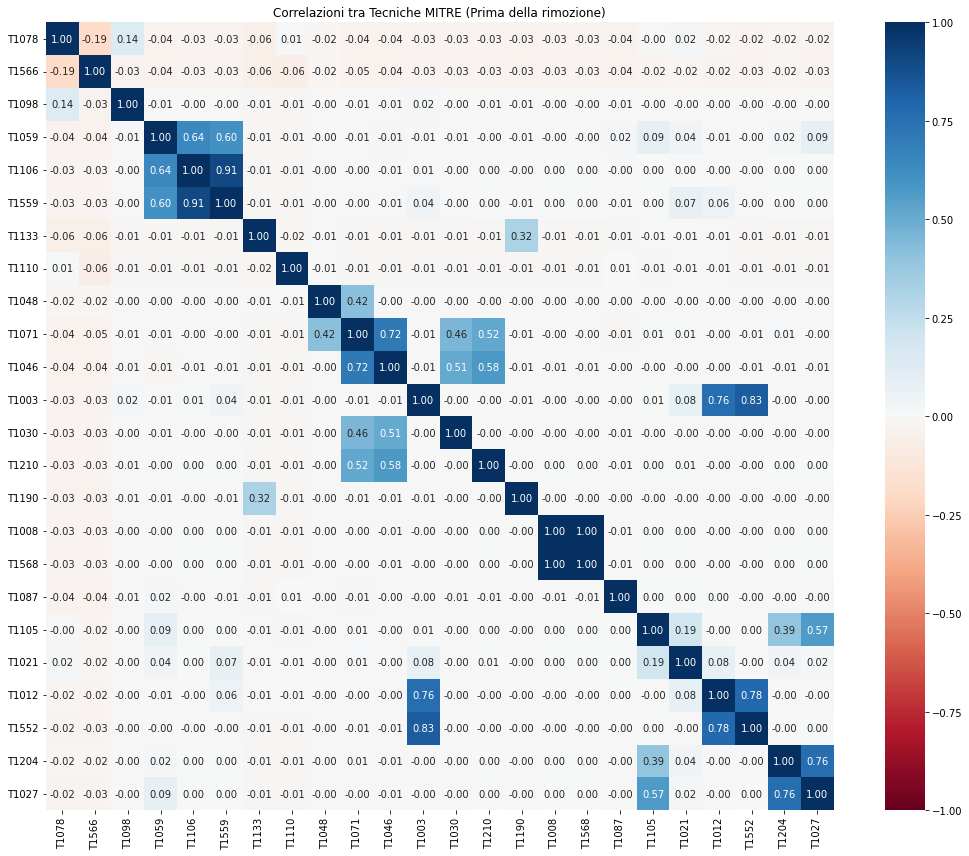


Esempio di tecniche altamente correlate prima della rimozione:

Correlazione: 0.905
- T1559: 43770 occorrenze
- T1106: 40487 occorrenze
→ Rimuovo: T1106

Correlazione: 0.998
- T1568: 40838 occorrenze
- T1008: 40646 occorrenze
→ Rimuovo: T1008

Correlazione: 0.831
- T1552: 31615 occorrenze
- T1003: 42745 occorrenze
→ Rimuovo: T1552
Tecniche rimosse per alta correlazione: {'T1008', 'T1552', 'T1106'}
Numero di tecniche rimanenti: 21
Tecniche rimosse per alta correlazione: {'T1008', 'T1552', 'T1106'}
Numero di tecniche rimanenti: 21


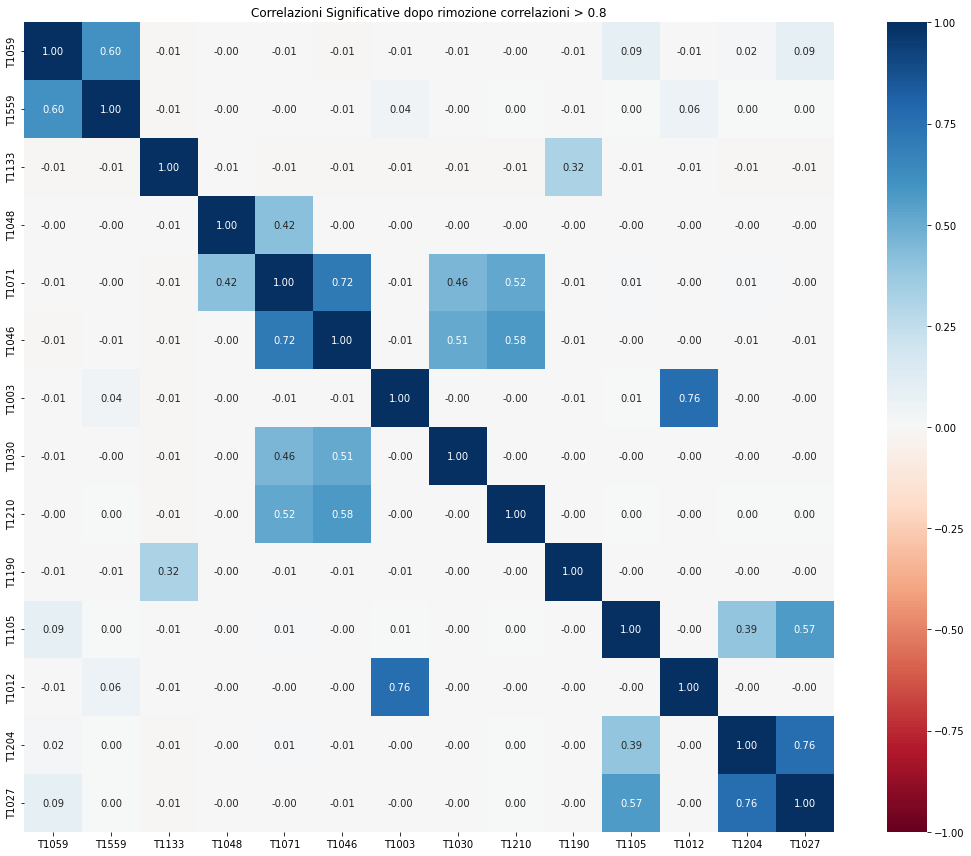


Riepilogo:
- Tecniche originali: 21
- Tecniche rimosse: 3
- Tecniche rimanenti: 21

Coppie di tecniche più correlate rimanenti (|corr| > 0.4):
T1027 <-> T1204: 0.763
T1012 <-> T1003: 0.763
T1046 <-> T1071: 0.719
T1559 <-> T1059: 0.602
T1210 <-> T1046: 0.577
T1027 <-> T1105: 0.569
T1210 <-> T1071: 0.521
T1030 <-> T1046: 0.508
T1030 <-> T1071: 0.456
T1071 <-> T1048: 0.416


In [15]:
# Importa le librerie necessarie per la visualizzazione
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la matrice di correlazione iniziale (escludiamo 'unknown' e 'n_rare')
correlation_matrix = encoded_df.drop(['unknown', 'n_rare'], axis=1).corr()

# Mostra la matrice di correlazione originale
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, 
            annot=True,
            cmap='RdBu',
            center=0,
            vmin=-1, vmax=1,
            fmt='.2f',
            square=True)
plt.title('Correlazioni tra Tecniche MITRE (Prima della rimozione)')
plt.tight_layout()
plt.show()

# Esempio prima della rimozione
print("\nEsempio di tecniche altamente correlate prima della rimozione:")
high_corr_example = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            tech1, tech2 = correlation_matrix.index[i], correlation_matrix.columns[j]
            count1, count2 = technique_counts[tech1], technique_counts[tech2]
            high_corr_example.append({
                'Tecnica 1': tech1,
                'Occorrenze 1': count1,
                'Tecnica 2': tech2,
                'Occorrenze 2': count2,
                'Correlazione': correlation_matrix.iloc[i, j]
            })
            if len(high_corr_example) == 3:  # Mostra solo i primi 3 esempi
                break
    if len(high_corr_example) == 3:
        break

for example in high_corr_example:
    print(f"\nCorrelazione: {example['Correlazione']:.3f}")
    print(f"- {example['Tecnica 1']}: {example['Occorrenze 1']} occorrenze")
    print(f"- {example['Tecnica 2']}: {example['Occorrenze 2']} occorrenze")
    print(f"→ Rimuovo: {example['Tecnica 1'] if example['Occorrenze 1'] < example['Occorrenze 2'] else example['Tecnica 2']}")

# Identifica le tecniche da eliminare (correlazione > 0.8)
techniques_to_remove = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            tech1 = correlation_matrix.index[i]
            tech2 = correlation_matrix.columns[j]
            # Confronta le occorrenze e rimuovi la tecnica meno frequente
            count1 = technique_counts[tech1]
            count2 = technique_counts[tech2]
            tech_to_remove = tech1 if count1 < count2 else tech2
            techniques_to_remove.add(tech_to_remove)

# Rimuovi le tecniche identificate
remaining_techniques = [col for col in correlation_matrix.columns if col not in techniques_to_remove]
filtered_df = encoded_df[remaining_techniques]

print(f"Tecniche rimosse per alta correlazione: {techniques_to_remove}")
print(f"Numero di tecniche rimanenti: {len(remaining_techniques)}")

# Ricalcola la matrice di correlazione con le tecniche rimanenti
correlation_matrix = filtered_df.corr()

# Trova le correlazioni significative (superiori a 0.3 in valore assoluto)
significant_corr = (correlation_matrix.abs() > 0.3) & (correlation_matrix != 1.0)
has_significant = significant_corr.any()
significant_features = correlation_matrix.index[has_significant]

# Filtra la matrice per mostrare solo le correlazioni significative
filtered_corr = correlation_matrix.loc[significant_features, significant_features]

# Dopo la rimozione, mostra la nuova matrice di correlazione
plt.figure(figsize=(15, 12))
sns.heatmap(filtered_corr, 
            annot=True,
            cmap='RdBu',
            center=0,
            vmin=-1, vmax=1,
            fmt='.2f',
            square=True)
plt.title('Correlazioni Significative dopo rimozione correlazioni > 0.8')
plt.tight_layout()
plt.show()

print(f"\nRiepilogo:")
print(f"- Tecniche originali: {len(correlation_matrix.columns)}")
print(f"- Tecniche rimosse: {len(techniques_to_remove)}")
print(f"- Tecniche rimanenti: {len(remaining_techniques)}")

# Mostra le coppie di tecniche più correlate rimanenti (|corr| > 0.4)
print("\nCoppie di tecniche più correlate rimanenti (|corr| > 0.4):")
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.4:
            high_corr.append((
                correlation_matrix.index[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

for tech1, tech2, corr in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
    print(f"{tech1} <-> {tech2}: {corr:.3f}")